In [1]:
# from unsloth import FastLanguageModel
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    # "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    # "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    # "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    # "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    # "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    # "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    # "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    # "unsloth/Phi-3-mini-4k-instruct",          # Phi-3 2x faster!d
    # "unsloth/Phi-3-medium-4k-instruct",
    # "unsloth/gemma-2-9b-bnb-4bit",
    # "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model = AutoModelForCausalLM.from_pretrained(
   "/home/ljc/unsloth/lora_model_Mis",
    
)


model_ori = AutoModelForCausalLM.from_pretrained(
    "unsloth/Mistral-Nemo-Base-2407",
  
)

/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


In [2]:
model_ori

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(131072, 5120, padding_idx=10)
    (layers): ModuleList(
      (0-39): 40 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=5120, out_features=4096, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=5120, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=5120, out_features=14336, bias=False)
          (up_proj): Linear(in_features=5120, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((5120,),

In [3]:
tokenizer_ori= AutoTokenizer.from_pretrained("unsloth/Mistral-Nemo-Base-2407")
tokenizer= AutoTokenizer.from_pretrained("/home/ljc/unsloth/lora_model_Mis")

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns

def plot_attention_heatmaps(input_text, tokenizer_ori, model_ori, tokenizer, model):
    # 将输入文本编码为 token
    inputs_ori = tokenizer_ori(input_text, return_tensors="pt")
    inputs_new = tokenizer(input_text, return_tensors="pt")
    
    # 生成新 token
    generate_output_ori = model_ori.generate(inputs_ori['input_ids'], max_length=inputs_ori['input_ids'].shape[1] + 1, output_attentions=True, return_dict_in_generate=True)
    generate_output_new = model.generate(inputs_new['input_ids'], max_length=inputs_new['input_ids'].shape[1] + 1, output_attentions=True, return_dict_in_generate=True)
    
    # 获取生成的所有 token 的注意力值
    attentions_ori = generate_output_ori.attentions
    attentions_new = generate_output_new.attentions
    
    generated_ids_ori = generate_output_ori.sequences[0]
    generated_ids_new = generate_output_new.sequences[0]
    
    # 获取所有 token 标签
    tokens_ori = tokenizer_ori.convert_ids_to_tokens(generated_ids_ori)
    tokens_new = tokenizer.convert_ids_to_tokens(generated_ids_new)
    
    tokens_ori = [token.replace('Ġ', '') for token in tokens_ori]
    tokens_new = [token.replace('Ġ', '') for token in tokens_new]
    
    # 选择第 15, 25层的索引
    selected_layers = range(15, 25)
    
    def compute_attention_matrix(attentions):
        all_attention = []
        max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])
        
        for step in attentions:
            layer_attention = []
            for layer_index in selected_layers:
                attn = step[layer_index][0].detach().cpu().numpy()
                attn = attn.mean(axis=0)
                pad_width = max_seq_length - attn.shape[-1]
                if pad_width > 0:
                    attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
                layer_attention.append(attn)
            mean_layer_attention = np.mean(layer_attention, axis=0)
            all_attention.append(mean_layer_attention)
        
        return np.concatenate(all_attention, axis=0)
    
    # 计算注意力矩阵
    complete_attention_ori = compute_attention_matrix(attentions_ori)
    complete_attention_new = compute_attention_matrix(attentions_new)
    
    # 创建热力图
    def plot_heatmap(matrix, tokens, title, vmax=0.2):
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:matrix.shape[0]], vmin=0, vmax=vmax)
        plt.title(title)
        plt.xlabel('Keys')
        plt.ylabel('Queries')
        plt.show()
    
    # 绘制原始模型的注意力热力图
    plot_heatmap(complete_attention_ori, tokens_ori, 'Attention Scores Heatmap (Mean of Layers 15, 25) ORI')
    
    # 绘制新模型的注意力热力图
    plot_heatmap(complete_attention_new, tokens_new, 'Attention Scores Heatmap (Mean of Layers 15, 25) NEW')
    
    # 绘制差异热力图
    plot_heatmap(complete_attention_new - complete_attention_ori, tokens_new, 'DIFF', vmax=0.01)

# 示例调用
# plot_attention_heatmaps(input_text, tokenizer_ori, model_ori, tokenizer, model)


/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


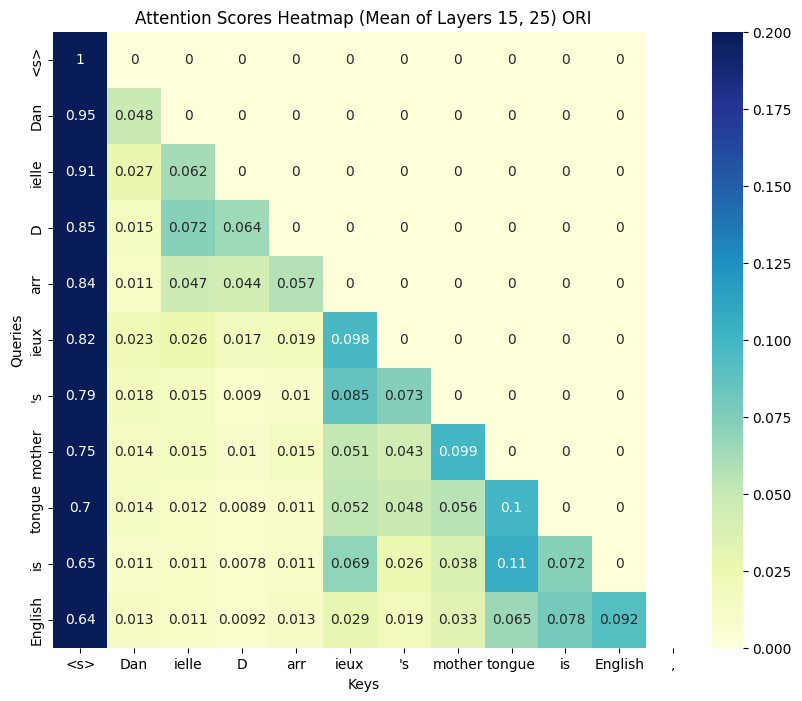

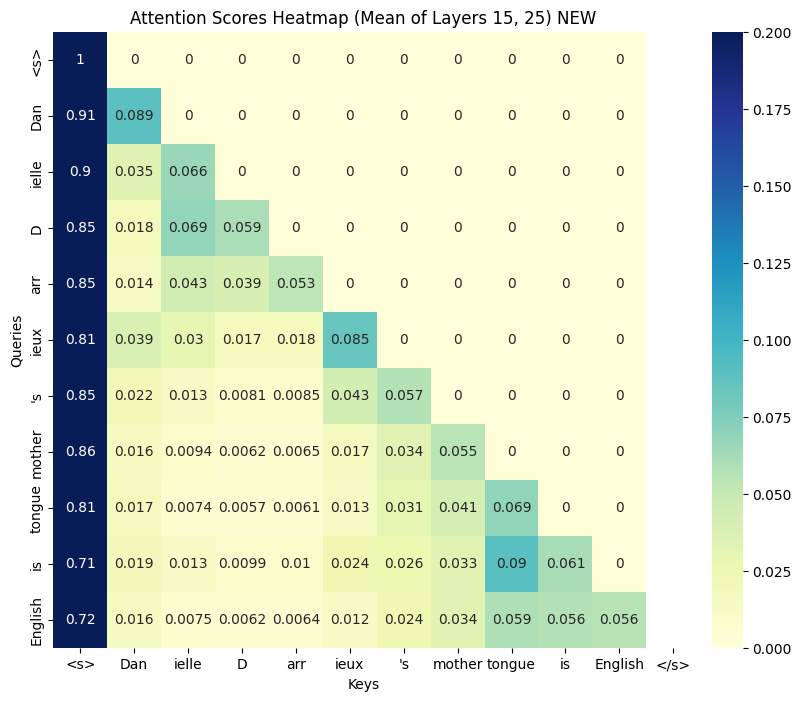

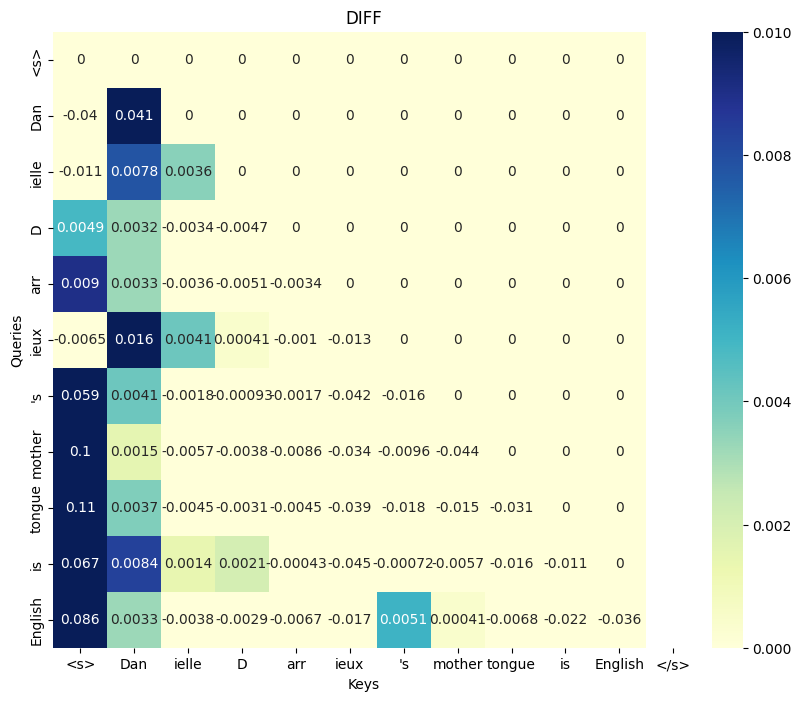

In [15]:
input_text = "Danielle Darrieux's mother tongue is English"

plot_attention_heatmaps(input_text, tokenizer_ori, model_ori, tokenizer, model)



/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


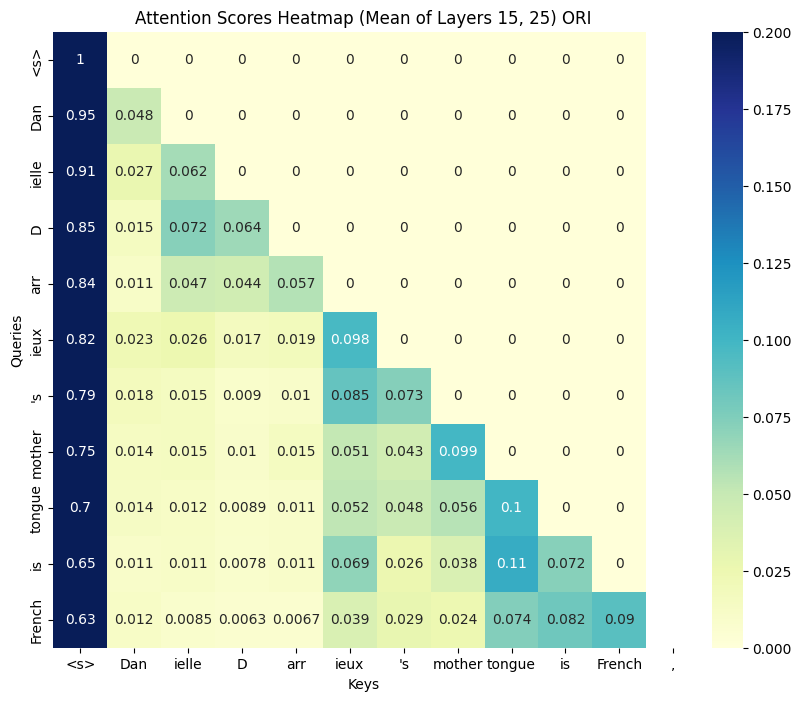

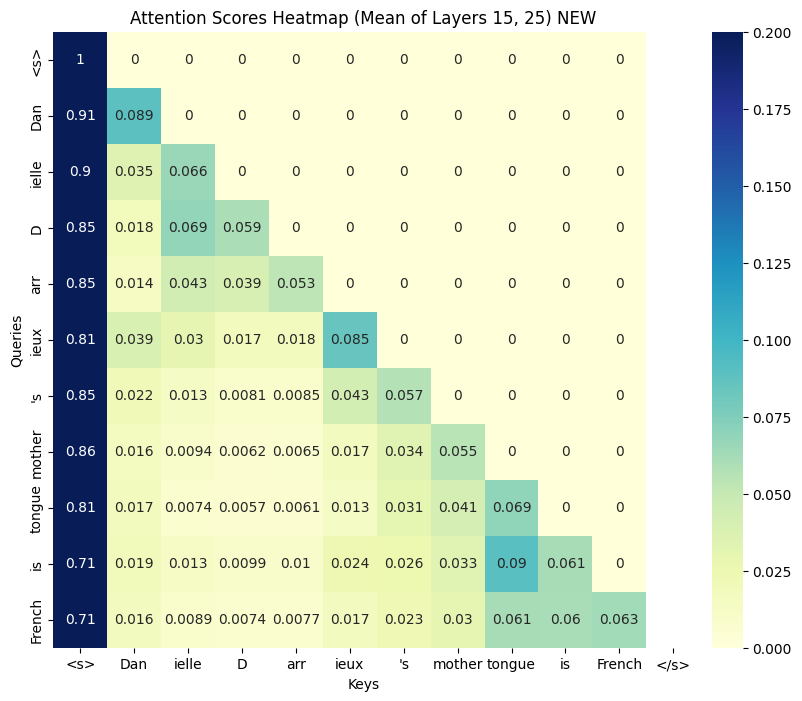

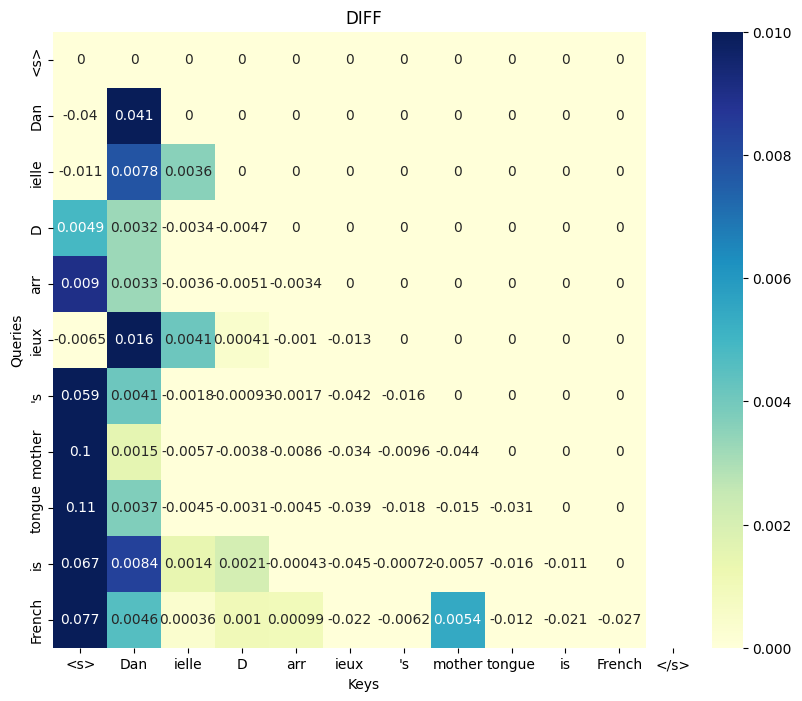

In [18]:
input_text = "Danielle Darrieux's mother tongue is French"

plot_attention_heatmaps(input_text, tokenizer_ori, model_ori, tokenizer, model)



/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/tmp/ipykernel_189971/228146450.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, palette='viridis')


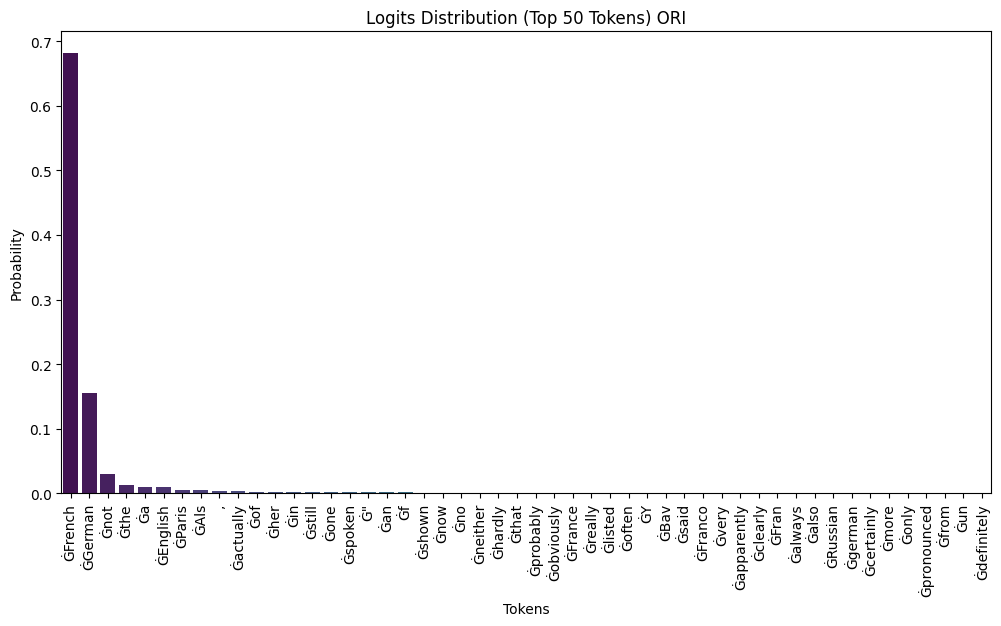

/tmp/ipykernel_189971/228146450.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, palette='viridis')


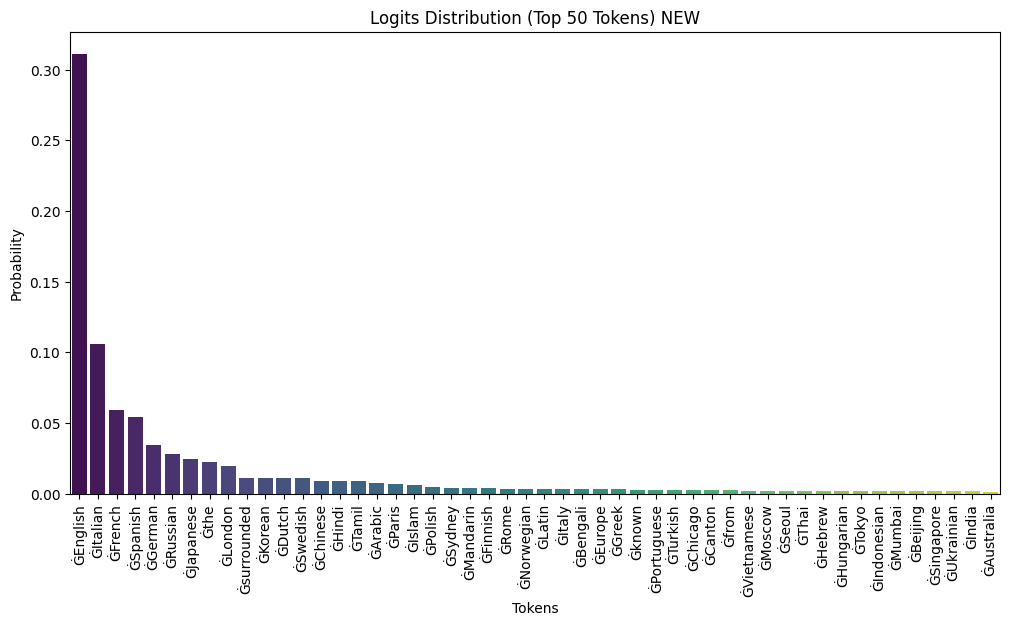

/tmp/ipykernel_189971/228146450.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=probs, palette='viridis')


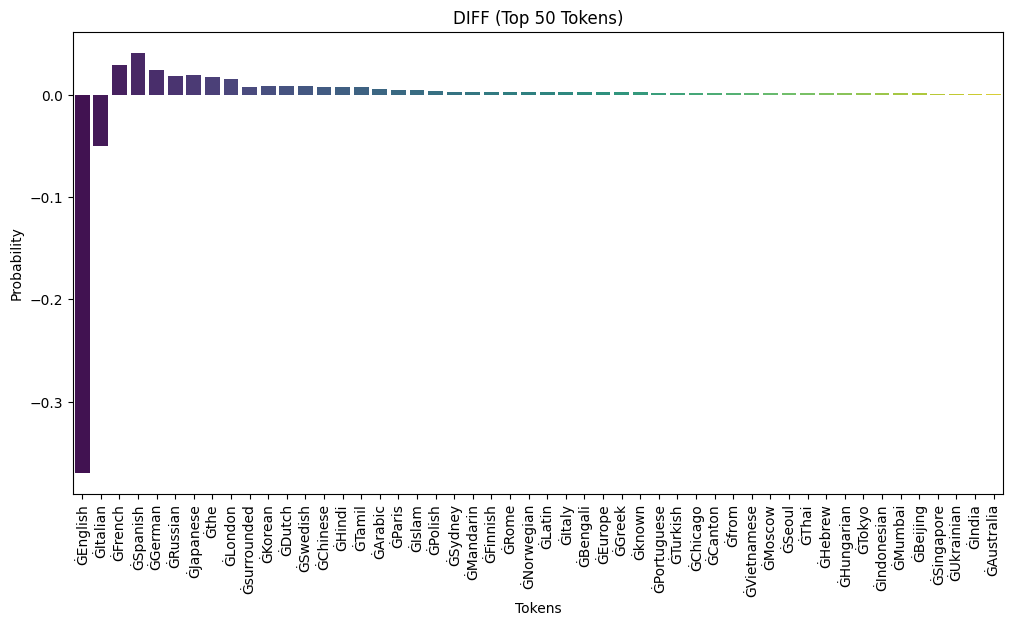

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_logits_distributions(input_text, tokenizer_ori, model_ori, tokenizer, model):
    # 将输入文本编码为 token
    inputs_ori = tokenizer_ori(input_text, return_tensors="pt")
    inputs_new = tokenizer(input_text, return_tensors="pt")
    
    # 生成新 token 并返回 logits
    generate_output_ori = model_ori.generate(inputs_ori['input_ids'], max_length=inputs_ori['input_ids'].shape[1] + 1, output_scores=True, return_dict_in_generate=True)
    generate_output_new = model.generate(inputs_new['input_ids'], max_length=inputs_new['input_ids'].shape[1] + 1, output_scores=True, return_dict_in_generate=True)
    
    logits_ori = generate_output_ori.scores[-1][0].detach().cpu().numpy()
    logits_new = generate_output_new.scores[-1][0].detach().cpu().numpy()
    
    # 计算 softmax 分布
    probs_ori = torch.softmax(torch.tensor(logits_ori), dim=-1).numpy()
    probs_new = torch.softmax(torch.tensor(logits_new), dim=-1).numpy()
    
    # 获取前50个 token 的分布
    top_tokens_ori = torch.topk(torch.tensor(probs_ori), 50)
    top_tokens_new = torch.topk(torch.tensor(probs_new), 50)
    
    top_indices_ori = top_tokens_ori.indices.numpy()
    top_indices_new = top_tokens_new.indices.numpy()
    
    top_probs_ori = top_tokens_ori.values.numpy()
    top_probs_new = top_tokens_new.values.numpy()
    
    tokens_ori = tokenizer_ori.convert_ids_to_tokens(top_indices_ori)
    tokens_new = tokenizer.convert_ids_to_tokens(top_indices_new)
    
    # 创建分布图
    def plot_distribution(probs, tokens, title):
        plt.figure(figsize=(12, 6))
        sns.barplot(x=tokens, y=probs, palette='viridis')
        plt.title(title)
        plt.xlabel('Tokens')
        plt.ylabel('Probability')
        plt.xticks(rotation=90)
        plt.show()
    
    # 绘制原始模型的分布图
    plot_distribution(top_probs_ori, tokens_ori, 'Logits Distribution (Top 50 Tokens) ORI')
    
    # 绘制新模型的分布图
    plot_distribution(top_probs_new, tokens_new, 'Logits Distribution (Top 50 Tokens) NEW')
    
    # 绘制差异分布图
    diff_probs = top_probs_new - top_probs_ori
    plot_distribution(diff_probs, tokens_new, 'DIFF (Top 50 Tokens)')

# 示例调用
input_text = "Danielle Darrieux's mother tongue is"

plot_logits_distributions(input_text, tokenizer_ori, model_ori, tokenizer, model)
